
So one way to visualize effectiveness of shut downs is to compare how quickly States shut down to the total number of currently expected deaths, normalized to population size of course.

In [1]:

# https://medium.com/@yinonweiss/lets-visualize-state-by-state-shutdown-effectiveness-on-covid-19-e13a5cdb50ad

In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

%pprint
%run ../../load_magic/storage.py
%run ../../load_magic/paths.py
%run ../../load_magic/lists.py
%run ../../load_magic/environment.py
%run ../../load_magic/dataframes.py

import scraping_utils
wikipedia = scraping_utils.wikipedia

from bs4 import BeautifulSoup as bs
import networkx as nx
import re
import urllib.request

notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
#pandemic_df = s.load_object('pandemic_df')
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])

dir()

Pretty printing has been turned OFF
D:\Documents\Repositories\notebooks\covid19\ipynb\Speed-to-shut-down Exploration.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['Config', 'In', 'Out', 'RandomForestClassifier', 'SequenceMatcher', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '__warningregistry__', '_dh', '_i', '_i1', '_i2', '_i3', '_ih', '_ii', '_iii', '_oh', 'bs', 'check_4_doubles', 'check_for_typos', 'conjunctify_list', 'copyfile', 'csv', 'encoding', 'example_iterrows', 'exit', 'filepath_regex', 'get_classifier', 'get_column_descriptions', 'get_data_structs_dataframe', 'get_datastructure_prediction', 'get_dir_tree', 'get_git_lfs_track_commands', 'get_importances', 'get_input_sample', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'get_specific_gitignore_files', 'get_struct_name', 'humanize_bytes', 'io', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'nx', 'os', 'pd', 'pickle', 'plt', 'preprocess_data', 'print_all_files_ending_starting_with', 'print_all_files_end

In [ ]:

!start %windir%\explorer.exe "{os.path.abspath(os.path.dirname(notebook_path))}"


---
# Load the Data

In [155]:

states_stats_df = s.load_object('states_stats_df')
columns_list = ['Census_Population_2010', 'Land_Area_sq_km', 'Date_Lockdown_Enacted']
states_stats_df[columns_list].sample(5)

,Census_Population_2010,Land_Area_sq_km,Date_Lockdown_Enacted
Delaware,897934,5047,2020-03-24
New Jersey,8791894,19047,2020-03-21
Mississippi,2967297,121531,2020-04-03
Illinois,12830632,143793,2020-03-21
South Carolina,4625364,77857,2020-04-07


In [6]:

states_current_numbers_df = s.load_object('states_current_numbers_df')
states_current_numbers_df.sample(5)

,Confirmed_Cumulative,Deaths_Cumulative,Recovered_Cumulative,Hospitalized_Cumulative
State_Name,,,,
Delaware,2323,61,423,224
Maine,633,19,266,120
Washington,10224,491,0,4668
Virgin Islands,51,1,43,0
Wyoming,287,2,164,0


In [8]:

usa_df = s.load_object('usa_df')
columns_list = ['Date', 'Confirmed_New', 'Confirmed_Cumulative', 'Deaths_New', 'Deaths_Cumulative']
usa_df.tail(5)[columns_list]

,Date,Confirmed_New,Confirmed_Cumulative,Deaths_New,Deaths_Cumulative
57,2020-04-12,28057.0,553493,1493.0,21936.0
58,2020-04-13,24685.0,578178,1462.0,23398.0
59,2020-04-14,25987.0,604165,2378.0,25776.0
60,2020-04-15,29465.0,633630,2438.0,28214.0
61,2020-04-16,32076.0,665706,2141.0,30355.0


In [10]:

us_deaths_df = s.load_object('us_deaths_df')
columns_list = ['Date', 'Deaths_New', 'Deaths_Cumulative']
us_deaths_df[columns_list].sample(5)

,Date,Deaths_New,Deaths_Cumulative
23,2020-03-24,162,681
8,2020-03-09,5,26
3,2020-03-03,3,9
14,2020-03-15,6,62
17,2020-03-18,26,123


In [58]:

us_states_df = s.load_object('nytimes_covid_19_data_us_states_df')
us_states_df.dd_smoothed.fillna(value=0, inplace=True)
us_states_df.columns = ['Date', 'State_Name', 'FIPS', 'Confirmed_Cumulative', 'Deaths_Cumulative', 'Deaths_Doubling', 'Confirmed_Doubling',
                        'State_Abbreviation', 'DD_Smoothed']
s.store_objects(us_states_df=us_states_df)
us_states_df.sample(5)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\us_states_df.pickle


,Date,State_Name,FIPS,Confirmed_Cumulative,Deaths_Cumulative,Deaths_Doubling,Confirmed_Doubling,State_Abbreviation,DD_Smoothed
830,2020-03-26,Kansas,20,171,3,NaN,3.039184,KS,2.310491
2355,2020-04-15,Washington,53,10783,572,19.824009,83.979843,WA,19.996013
1682,2020-03-31,Ohio,39,2199,55,2.541540,5.730190,OH,3.157670
1702,2020-03-09,Oklahoma,40,1,0,NaN,NaN,OK,0.000000
2459,2020-04-16,Wisconsin,55,3875,197,10.503846,17.441203,WI,9.381707


In [61]:

'Deaths_Cumulative' in column_description_dict

False

In [62]:

column_description_dict['Deaths_Cumulative'] = 'Cumulative Deaths'
s.store_objects(column_description_dict=column_description_dict)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\column_description_dict.pickle


In [78]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
def get_lockdown_today_correlation(column_name):
    x_list = []
    y_list = []
    label_list = []
    for state_name, row_series in states_stats_df.iterrows():
        date_enacted = row_series.Date_Lockdown_Enacted
        state_match_series = (us_states_df.State_Name == state_name)
        mask_series = (us_states_df.Date == date_enacted) & state_match_series
        df1 = us_states_df[mask_series]
        date_max = us_states_df[state_match_series].Date.max()
        mask_series = (us_states_df.Date == date_max) & state_match_series
        df2 = us_states_df[mask_series]
        if (df1.shape[0] > 0) and (df2.shape[0] > 0):
            beginning_value = df1[column_name].squeeze()
            ending_value = df2[column_name].squeeze()
            if (beginning_value > 0) and (ending_value > 0):
                x_list.append(beginning_value)
                y_list.append(ending_value)
                label_list.append(state_abbreviation_dict[state_name])
    
    return x_list, y_list, label_list

In [100]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
def get_threshold_today_correlation(column_name):
    x_list = []
    y_list = []
    label_list = []
    for state_name, row_series in states_stats_df.iterrows():
        
        # Get enactment value
        date_enacted = row_series.Date_Lockdown_Enacted
        state_match_series = (us_states_df.State_Name == state_name)
        mask_series = (us_states_df.Date == date_enacted) & state_match_series
        df_enacted = us_states_df[mask_series]
        
        # Get today's value
        date_max = us_states_df[state_match_series].Date.max()
        mask_series = (us_states_df.Date == date_max) & state_match_series
        df_max = us_states_df[mask_series]
        
        # Get the value when it reached a threshold
        mask_series = (us_states_df[column_name] >= 100) & state_match_series
        date_min = us_states_df[mask_series].Date.min()
        mask_series = (us_states_df.Date == date_min) & state_match_series
        df_min = us_states_df[mask_series]
        
        if (df_enacted.shape[0] > 0) and (df_max.shape[0] > 0) and (df_min.shape[0] > 0):
            enactment_value = df_enacted[column_name].squeeze()
            now_value = df_max[column_name].squeeze()
            threshold_value = df_min[column_name].squeeze()
            if (now_value > 0) and (enactment_value > 0):
                x_list.append(enactment_value - threshold_value)
                y_list.append(now_value)
                label_list.append(state_abbreviation_dict[state_name])
    
    return x_list, y_list, label_list

In [146]:

state_abbreviation_dict = s.load_object('state_abbreviation_dict')
def get_threshold_density_correlation(column_name):
    x_list = []
    y_list = []
    label_list = []
    for state_name, row_series in states_stats_df.iterrows():
        
        # Get population density
        state_match_series = (states_stats_df.index == state_name)
        population = states_stats_df[state_match_series].Census_Population_2010.squeeze()
        area = states_stats_df[state_match_series].Land_Area_sq_km.squeeze()
        population_density = population/area
        
        # Get enactment value
        date_enacted = row_series.Date_Lockdown_Enacted
        state_match_series = (us_states_df.State_Name == state_name)
        mask_series = (us_states_df.Date == date_enacted) & state_match_series
        df_enacted = us_states_df[mask_series]
        
        # Get today's value
        date_max = us_states_df[state_match_series].Date.max()
        mask_series = (us_states_df.Date == date_max) & state_match_series
        df_max = us_states_df[mask_series]
        
        # Get the value when it reached a threshold
        mask_series = (us_states_df[column_name] >= 100) & state_match_series
        date_min = us_states_df[mask_series].Date.min()
        mask_series = (us_states_df.Date == date_min) & state_match_series
        df_min = us_states_df[mask_series]
        
        if (df_enacted.shape[0] > 0) and (df_max.shape[0] > 0) and (df_min.shape[0] > 0):
            enactment_value = df_enacted[column_name].squeeze()
            now_value = df_max[column_name].squeeze()
            threshold_value = df_min[column_name].squeeze()
            if (now_value > 0) and (enactment_value > 0):
                x_list.append((enactment_value - threshold_value)/population_density)
                y_list.append(now_value/population_density)
                label_list.append(state_abbreviation_dict[state_name])
    
    return x_list, y_list, label_list

In [51]:

column_description_dict = s.load_object('column_description_dict')
def get_column_description(column_name):
    if column_name in column_description_dict:
        column_description = column_description_dict[column_name]
    else:
        column_description = re.sub('^pf_', 'Personal Freedom:_', str(column_name), 1)
        column_description = re.sub('^hf_', 'Human Freedom:_', str(column_description), 1)
        column_description = re.sub('^ef_', 'Economic Freedom:_', str(column_description), 1)
        column_list = column_description.split('_')
        descr_list = []
        for word in column_list:
            descr_list.append(word[0].upper()+word[1:])
        column_description = ' '.join(descr_list)
        column_description_dict[column_name] = column_description
        s.store_objects(column_description_dict=column_description_dict)
    
    return column_description

In [151]:

import seaborn as sns
import numpy as np

def show_x_y_labels(column_name, x_y_label_function, xlabel_suffix=' at time of Lockdown', ylabel_suffix=' Today'):
    fig = plt.figure(figsize=(18, 8))
    ax = fig.add_subplot(111, autoscale_on=True)
    Text_obj = ax.set_xlabel('{}{}'.format(column_description_dict[column_name], xlabel_suffix))
    Text_obj = ax.set_ylabel('{}{}'.format(column_description_dict[column_name], ylabel_suffix))
    x_list, y_list, label_list = x_y_label_function(column_name)
    kwargs = dict(textcoords='offset points', ha='left', va='bottom',
                  bbox=dict(boxstyle='round,pad=0.25', alpha=0.5), fontsize='x-small')
    scatter_kws = dict(alpha=0.0)
    for state_name, x, y in zip(label_list, x_list, y_list):
        annotation = ax.annotate('{}'.format(state_name), xy=(x, y), xytext=(-5, -8), **kwargs)
    AxesSubplot_obj = sns.regplot(x_list, y_list, scatter_kws=scatter_kws, ax=ax)
    fig.suptitle(t='"I will strew your flesh upon the mountains and fill the valleys with your carcass" Ezekiel 32:5', x=0.5, y=0.91)

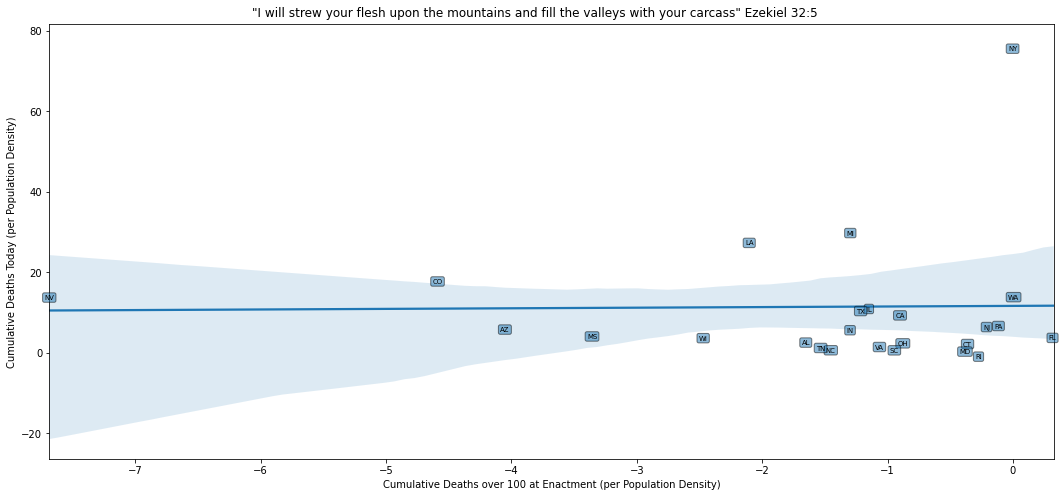

In [152]:

show_x_y_labels('Deaths_Cumulative', get_threshold_density_correlation,
                ' over 100 at Enactment (per Population Density)', ' Today (per Population Density)')

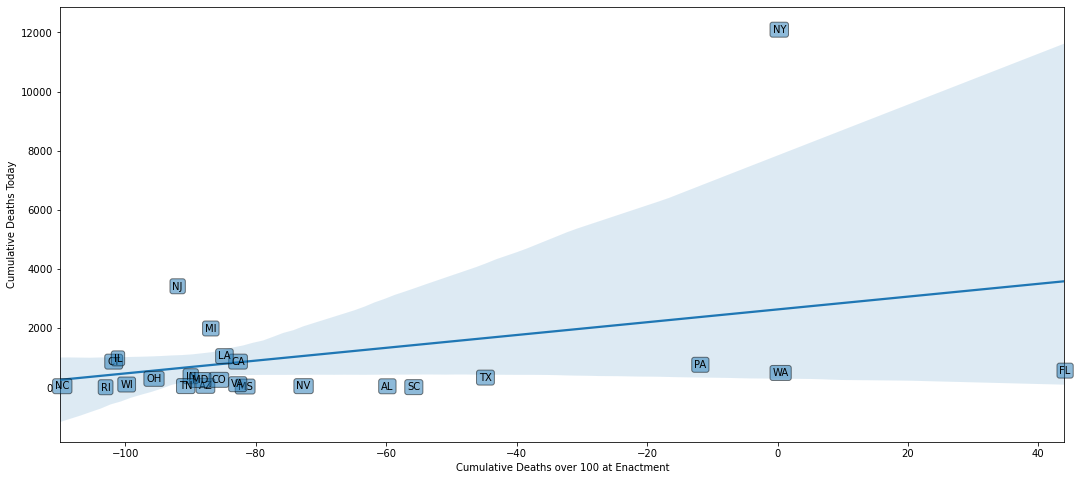

In [101]:

show_x_y_labels('Deaths_Cumulative', get_threshold_today_correlation, ' over 100 at Enactment')

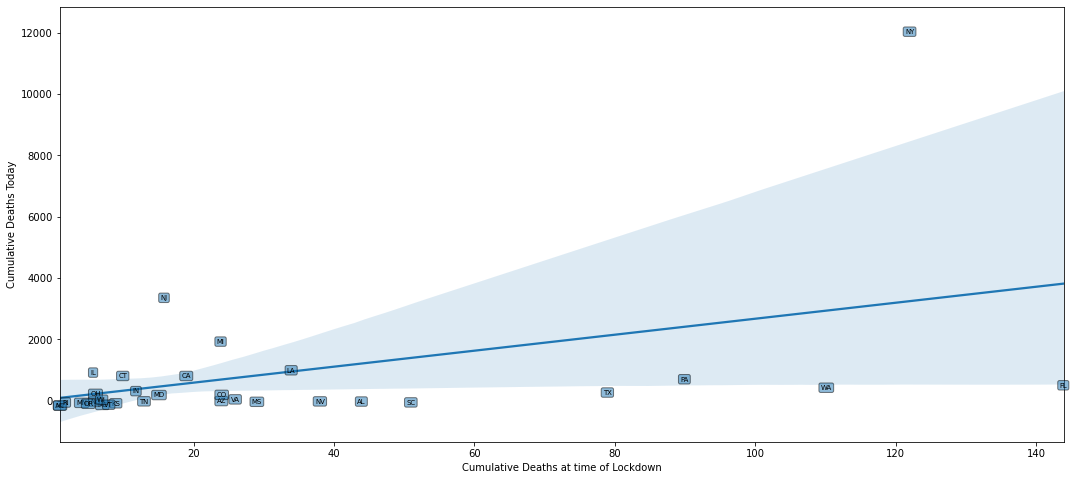

In [76]:

show_x_y_labels('Deaths_Cumulative', get_lockdown_today_correlation)


---
# Scrape the Data